In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

In [27]:
style.use('seaborn-darkgrid')

## Problem Statement

Defining   an    "adopted   user"   as   a   user   who has   logged   into   the   product   on   three   separate days   in   at   least   one   seven day   period ,   identify   which   factors   predict   future   user adoption

There are two datasets used in this project, one with user data and one with user logins. The first step will be to merge the two and create a column of adopted users. 

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.creation_time = pd.to_datetime(users.creation_time)
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [4]:
users.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
users = users.fillna(0)

In [7]:
logins = pd.read_csv('takehome_user_engagement.csv', index_col='time_stamp', parse_dates=True)

In [8]:
logins.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [9]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
dtypes: int64(2)
memory usage: 4.8 MB


In [10]:
logins_agg = logins.groupby('user_id').resample('1W').sum()

In [11]:
logins_agg.head()

user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0

In [12]:
logins_agg = logins_agg[logins_agg['user_id'].isnull()==False].drop('user_id',axis=1)

In [13]:
active_users = logins_agg.loc[logins_agg['visited'] >= 3]

In [14]:
active_users.tail()

visited
user_id time_stamp         
11988   2014-04-06        3
        2014-05-04        4
        2014-05-18        3
        2014-05-25        5
        2014-06-01        3

In [15]:
active_users = active_users.groupby(level=0).apply(np.sum)
active_users = active_users[active_users!=0]
active_users = pd.DataFrame(active_users,index=active_users.index)
active_users.columns = ['Active Weeks']
active_users.head(5)

,Active Weeks
user_id,
2,3
10,249
20,3
33,3
42,331


In [17]:
users=users.rename(columns={'object_id':'user_id'})
df_active = active_users.merge(users,left_index=True,right_on='user_id',how='inner')
df_active.head()

,Active Weeks,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
9,249,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0
19,3,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,2014-05-29 11:46:38,0,0,58,0.0
32,3,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,2014-05-31 06:29:09,0,0,401,79.0
41,331,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,2014-05-25 19:05:07,1,0,235,0.0


In [18]:
df_active['Active']=1

In [19]:
users['Active']=int(0)
users.iloc[list(df_active.index),10]=1
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
Active                        12000 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 1.0+ MB


In [21]:
users.Active.value_counts()

0    10555
1     1445
Name: Active, dtype: int64

In [22]:
users = users.set_index('user_id').sort_index()

In [23]:
users = users.drop([ 'name', 'email', 'last_session_creation_time'],axis=1)

In [25]:
users_modeling = pd.get_dummies(users)
users_modeling.head()

,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,
1,2014-04-22 03:53:30,1,0,11,10803.0,0,1,0,0,0,0
2,2013-11-15 03:45:04,0,0,1,316.0,1,0,1,0,0,0
3,2013-03-19 23:14:52,0,0,94,1525.0,0,0,1,0,0,0
4,2013-05-21 08:09:28,0,0,1,5151.0,0,1,0,0,0,0
5,2013-01-17 10:14:20,0,0,193,5240.0,0,1,0,0,0,0


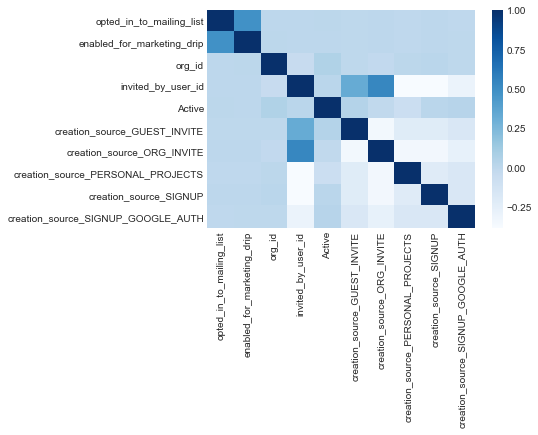

In [32]:
corr = users_modeling.corr()

sns.heatmap(corr, cmap='Blues')
plt.show()

From the initial heatmap, the strongest correlations with active users appear to be creation source and org id. Next we'll train a predictive model and look at the feature importances. 

In [40]:
users_modeling['creation_time'] = users_modeling['creation_time'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [41]:
X = users_modeling.drop(['Active'], axis=1)
y = users_modeling['Active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [42]:
param_grid = {'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1)

grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed: 66.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [45]:
clf = grid_search.best_estimator_
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 200}

In [46]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=80, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

0.8821111111111111 0.8786666666666667


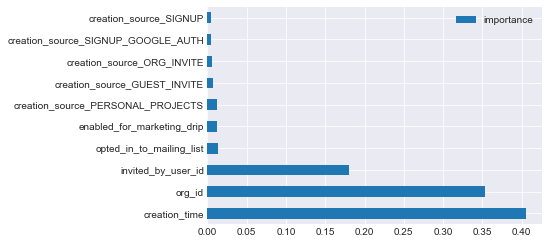

In [53]:
features = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
features.plot(kind='barh')

The feature importances identify creation time, org_id, and invited_by_user_id as by far the most important factors for user adoption. We will further examine the org_id feature for additional insights. 

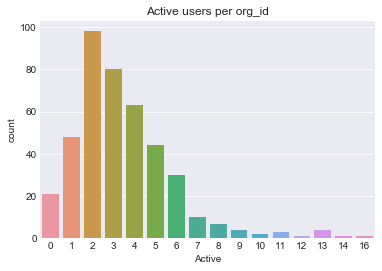

In [77]:
org = users.groupby('org_id').sum()
sns.countplot(org['Active'].sort_values( ascending=False))
plt.title('Active users per org_id')
plt.show()

We can see that certain org_id's have much more adopted users than others. We don't have any additional data relating to org_id, but given additional data it would be possible to identify which types of organization are more likely to use the product. 